In [53]:
#Packages to be loaded. Probably there are duplicated or missing ones
import cobaya
import camb
import numpy as np
import sympy
import math
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import scipy.integrate as integrate

# Cosmological parameters #

In [54]:
#Cosmological constants
c = 2.99792458E5;   HJPAS = 1/(c/100);

#Parameteres that won't be sampled. These parameters will be the same as the ones given to Cobaya
gamma = 0.545; OmegakJPAS = 0; AsJPAS = 2.09052E-9; nsJPAS = 0.9626; tauJPAS = 0.06; mnuJPAS = 0.0; nmuJPAS = 3.046;

#A set of cosmological parameters outside the fiducial cosmology matching Cobaya's cosmology
hJPAS = 0.674
OmegabJPASh2 = 0.02212
OmegaCDMJPASh2 = 0.1206

#Indirect cosmological parameters outside the fiducial
H0JPAS = hJPAS*100
OmegabJPAS = OmegabJPASh2/hJPAS**2; OmegaCDMJPAS = OmegaCDMJPASh2/hJPAS**2;

In [55]:
#Fiducial cosmology functions and constants (including FoG parameter)
OmegamFid = 0.31417

#At z=1.7 (first bin)
EzFid = 2.6210003044889154
XiFid = 3263.0797256936944
DAFid = 1208.54804655322
sigmapFid = 2.725068353464309

In [56]:
#Parámetros de LSS de JPAS
DeltazJPAS = 0.00364236313918151
fsky = 0.2575

def bJPAS(z):
    return 0.53+0.289*(1+z)**2

In [57]:
def PrimordialPowerLaw(As,ns,k):
    return As*(k/(0.05/hJPAS))**(ns-1)

# k and z binning #

In [58]:
#Arrays limits and steps.

#K arrays. In h units

kminKArrayCompleto = 0.001;   kmaxKArrayCompleto = 2.4900;  pasoKArrayCompleto = 0.025;
zmin = 1.7;   zmax = 2.9;   pasoz = 0.2;

#k binning, complete and in a reduced scaleset
KArrayCompleto = np.exp(np.arange(math.log(kminKArrayCompleto), math.log(kmaxKArrayCompleto), pasoKArrayCompleto) )
KArray = KArrayCompleto[range(121,246)]

#k binning on lower and upper limits
KArrayUpper = np.zeros(len(KArray)); KArrayLower = np.zeros(len(KArray));

for i in range(0, len(KArray)-1):
    KArrayUpper[i] = KArray[i] + (KArray[i+1]-KArray[i])/2;   KArrayLower[i] = KArray[i] - (KArray[i+1]-KArray[i])/2;

KArrayUpper[-1] = KArrayUpper[-2];  KArrayLower[-1] = KArrayLower[-2];


#z binning

#Original one
zaAntes = np.arange(zmin-0.1, zmax+pasoz/2, pasoz)

#Including z=0
zaAdicional = np.array([0])

#Binning including all lower and upper z-bins limits
zaConBines = np.arange(zmin-pasoz/2, zmax+0.01+pasoz/2, pasoz/2)

#z binning with 0 and including z-bin limits
za = np.concatenate((zaAdicional,zaConBines))

#Positions of upper and lower limits of the z-bins in the za array
positions_Upper = [3, 5, 7, 9, 11, 13, 15]
positions_Lower = [1, 3, 5, 7, 9, 11, 13]

# P(k) data and densities reading #

In [59]:
KArray[91]

0.20033680997480682

In [60]:
# Define a class to read the simulated data (Pk, densities) and the seed specifying the path as input
def read_data(path_to_data):
    data = {}

    Simulated_pk_filename = path_to_data+'Pk_Simulated_Data_HighZ_NoFeature.dat'
    Simulated_densities = path_to_data+'Densities_HighZ.dat'
    Vector_Seed = path_to_data+'SeedVector.dat'

    data['pkz'] = np.zeros((len(zaAntes), len(KArray)))
    data['ndz'] = np.zeros(len(zaAntes))
    data['vs'] = np.zeros(len(KArray))
  
    with open(Simulated_pk_filename) as file:
        for i in range(len(KArray)):
            line = file.readline().split()
            data['pkz'][0][i] = float(line[1])

    with open(Simulated_densities) as file:
        for i in range(len(zaAntes)):
            line = file.readline().split()
            data['ndz'][i] = float(line[1])

    with open(Vector_Seed) as file:
        for i in range(len(KArray)):
            line = file.readline().split()
            data['vs'][i] = float(line[0])
            
    return data

# Read data is converted in the dictionary 'data'

#data = read_data('/gpfs/users/martinezg/Simulated_Data/')
data = read_data('/Users/guillermo/Desktop/Simulated_Data/')
data.keys()

dict_keys(['pkz', 'ndz', 'vs'])

# CAMB settings and results #

In [61]:
# Let's try to obtain a PPS and Pm with nodes using CAMB


nodes_k = [KArray[0], KArray[69], KArray[-1]]  # x-values of the two points
nodes_PPS = [PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[0]), PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[69]), 
             PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[-1])]  # y-values of the two points

nodes_logk = np.log(nodes_k)
nodes_logPPS = np.log(nodes_PPS)

#Node interpolation. With just 2, always linear
NodesInterpFunc = interp1d(nodes_logk, nodes_logPPS,
                axis=0,  #This command interpolates among columns
                bounds_error=False,
                kind='linear',
                fill_value=(nodes_logPPS[0], nodes_logPPS[-1]))


#Parameter set 'pars' for CAMB, with its cosmology, a modified PPS and a P(m) including the nodes
from camb import model
pars = camb.CAMBparams()

#Cosmological parameters
pars.set_cosmology(H0=H0JPAS, ombh2=OmegabJPASh2, omch2=OmegaCDMJPASh2, mnu=mnuJPAS, omk=OmegakJPAS, tau=tauJPAS)
#pars.max_eta_k = 5000.0
#pars.YHe = 0.24597825866420944
#pars.InitPower.set_params(As=AsJPAS, ns=nsJPAS, r=0)

#PPS as a power law
#pars.InitPower.set_params(As=AsJPAS, ns=nsJPAS)
pars.InitPower = camb.initialpower.SplinedInitialPower()
pars.InitPower.set_scalar_log_regular(KArray[0]*hJPAS, KArray[-1]*hJPAS, np.exp(NodesInterpFunc(np.log(KArray))))
#pars.InitPower.set_scalar_table(nodes_k, nodes_PPS)

#Pmatter according to the modified PPS
pars.set_matter_power(redshifts=za, kmax=10)
pars.NonLinear = model.NonLinear_none

Note: redshifts have been re-sorted (earliest first)


In [62]:
#CAMB matter power spectrum Pm(k) with the primordial nodes included.

results = camb.get_results(pars) #Resultados de CAMB
kCAMB, zCAMB, pCAMB = results.get_matter_power_spectrum(minkh=KArray[0], maxkh=KArray[-1], npoints = len(KArray))

[matplotlib.mathtext] Substituting symbol R from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol R from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol R from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol R from STIXNonUnicode


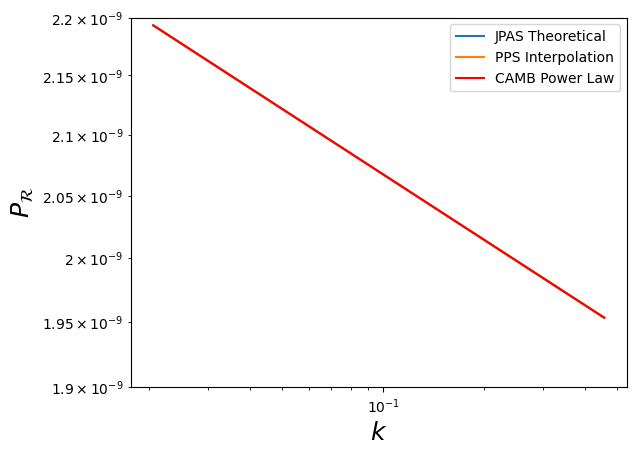

In [63]:
#Representamos el P(k):
plt.plot(figsize=(8,4))
plt.loglog(KArray,PrimordialPowerLaw(AsJPAS,nsJPAS,KArray), label = 'JPAS Theoretical')
plt.loglog(KArray, np.exp(NodesInterpFunc(np.log(KArray))), label = "PPS Interpolation"); #Se pinta la interpolación
plt.loglog(KArray, pars.scalar_power(KArray*hJPAS), label= "CAMB Power Law", color='red'); #Se pinta lo obtenido por CAMB
plt.ylabel(r'$P_\mathcal{R}$', fontsize=18)
plt.xlabel(r'$k$', fontsize=18);
#plt.xlim(1e-2, 0.1);
plt.ylim(1.9e-9, 2.2e-9);
plt.legend();

# Classes to interface with Cobaya #

In [64]:
#If previous is OK, now the classes to interface with Cobaya are created.

#A cobaya theory NodesInPrimordialPk and a cobaya external likelihood Pklike classes are created

#Needed packages
from cobaya.theory import Theory
from cobaya.likelihood import Likelihood

In [65]:
#Class of the theory, with the PPS modification including the nodes
class NodesInPrimordialPk(Theory):

    def initialize(self): #Initialize self with the k-array
        self.ks = KArray

    #It seems that in here we allocate the values of the parameters to be sampled and definme their names
    def calculate(self, state, want_derived=True, **params_values_dict):

        #Variables k1, k2... P1, P2... Allocated here
        #nodes_k = [params_values_dict['k1'], params_values_dict['k2'], params_values_dict['k3']  ] 
        #nodes_PPS = [params_values_dict['P1'], params_values_dict['P2'], params_values_dict['P3']] 

        nodes_logk = np.log([params_values_dict['k1'], params_values_dict['k2'], params_values_dict['k3'] ] )
        nodes_logPPS = np.log([params_values_dict['P1'], params_values_dict['P2'], params_values_dict['P3'] ] )

        
        #nodes_k and nodes_PPS are interpolated
        NodesInterpFunc_nodes = interp1d(nodes_logk, nodes_logPPS,
                axis=0,  # interpolate along columns
                bounds_error=False,
                kind='linear',
                fill_value=(nodes_logPPS[0], nodes_logPPS[-1]))
        
        #We construct a modified PPS(k) is evaluated at our nodes, evaluated at our array
        state['primordial_scalar_pk'] = {'kmin': KArray[0], 'kmax': KArray[-1],
                                         'Pk': np.exp(NodesInterpFunc_nodes(np.log(KArray))), 'log_regular': True}

    #To be able to evaluate the PPS?
    def get_primordial_scalar_pk(self):
        return self.current_state['primordial_scalar_pk']
   
    #Function that returns the nodes parameters values
    def get_can_support_params(self):
        return ['k1', 'k2', 'k3', 'P1', 'P2', 'P3']


In [66]:
#Class incorporating the monopole and the likelihood. 


class Pklike(Likelihood): #Class is defined
    
    def initialize(self):  

        #Path in wich the data are. We call read_data with this path.
        #self.data = read_data('/gpfs/users/martinezg/Simulated_Data/')
        self.data = read_data('/Users/guillermo/Desktop/Simulated_Data/')

        #Grid of K
        self.ks = KArray
        
        #Grid of z to be employed
        self.z_win = za

    
    def get_requirements(self): #¿Por qué es necesario tener requisitos? ¿No puedo usar las funciones sin esto?
                                #¿Interpolator en extended o completo?
        
        return {'omegam': None,                
                'Pk_interpolator': {'z': self.z_win, 'k_max': 10, 'nonlinear': False, 'vars_pairs': ([['delta_tot', 'delta_tot']])},
                'comoving_radial_distance': {'z': self.z_win},
                'angular_diameter_distance': {'z': self.z_win},
                'Hubble': {'z': self.z_win, 'units': 'km/s/Mpc'},
                'sigma8_z': {'z': self.z_win}, 'fsigma8': {'z': self.z_win},
                 #'fsigma8': {'z': self.z_win, 'units': None},
                'CAMBdata': None}
 
    #Definition of the monopole. It will return:
        #The monopole evaluated at z=1.7 and array of k
        #The covariance evaluated at z=1.8 and array of k
    
    def monopole(self, **params_dic):

        resultsCobaya = self.provider.get_CAMBdata()   #CAMB results in resultsCobaya   
        
        # All functions and variables to compute the Kaiser model. It reads the cosmology from info (below)
        Omegam = self.provider.get_param('omegam')  


        Ez = np.sqrt( Omegam*(1+self.z_win)**3+(1-Omegam) ); 
        H = HJPAS * Ez
        f = (Omegam*(1+self.z_win)**3*1/(Ez**2))**gamma


        #A and R parameters withouth D(z) (thus calculating online Pm(1.7))
        A = bJPAS(za)
        R = f

        # This is the matter power spectrum interpolator:
        pkCobaya = self.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False)    #P matter is obtained here
        
        # Photometric factor
        sigmar = DeltazJPAS*(1+self.z_win)/H

        # Fingers of God effect at z = 1.7 in the fiducial

        def FFog(mu,k):
            return 1/(1+(f[2]*k*mu*sigmapFid)**2)


        # AP effect
        Xi = self.provider.get_comoving_radial_distance(self.z_win)*hJPAS;
        DA = Xi/(1+self.z_win);
        FactorAP = DAFid**2*EzFid/( DA[2]**2*EzFid )

        def Q(mu):
            return ((Ez[2]**2*Xi[2]**2*mu**2-EzFid**2*XiFid**2*(mu**2-1))**0.5/(EzFid*Xi[2]))
 
        def muObs(mu):
            return mu*Ez[2]/(EzFid*Q(mu))
           
        def kObs(mu,k):
            return Q(mu)*k 


        #P galaxy
        def Pg(mu,k):
            return FactorAP*FFog(muObs(mu),kObs(mu,k))*(A[2]+R[2]*muObs(mu)**2)**2 * (   hJPAS**3*pkCobaya.P(self.z_win[2],kObs(mu,k)*hJPAS)   ) *np.exp(-(k*mu*sigmar[2])**2)
            
         #P galaxy
        def Pg(mu,k):
            return (A[2]+R[2]*mu**2)**2 * (   hJPAS**3*pkCobaya.P(self.z_win[2],k*hJPAS)   ) *np.exp(-(k*mu*sigmar[2])**2) 
            
        #Trapezoid rule with 2000 steps for computing the Pmonopole(k)
        def Pgmonopole(k):
            mu = np.arange(-1, 1, 1/1000)
            return 1/2 * integrate.trapz(Pg(mu, k), mu)

        PgmonopoleValores = np.zeros(len(self.ks))

        for i in range(0, len(self.ks)):
             PgmonopoleValores[i] = Pgmonopole(self.ks[i])

        #Covariance
        
        #Densities are red from self.data['ndz].

        #Definition of the volume (requires angular distance and za lower/upper bining)


        #Angular distance for z upper and lower bins.

        XiZaLower = self.provider.get_comoving_radial_distance(self.z_win[positions_Lower])*hJPAS
        XiZaUpper = self.provider.get_comoving_radial_distance(self.z_win[positions_Upper])*hJPAS
        
        #Definition of the volume between redshift bins
        Vol = 4*np.pi*fsky/3*(XiZaUpper**3-XiZaLower**3)
   
        #Number of modes. It depends of ksup and kinf corresponding to kupper y klower
        def Nk(ksup,kinf):
            return Vol[0] * (4*np.pi/3*(ksup**3-kinf**3))/((2*np.pi)**3)

        #Nk evaluated for each of our k-bins
        NkEvaluado = np.zeros(len(self.ks))
        for i in range(0, len(self.ks)):
            NkEvaluado[i] = Nk(KArrayUpper[i],KArrayLower[i])
        
        #Covariance Cov definition
        def Cov(k,k1,k2):
            return 2 * (Pgmonopole(k) + 1/self.data['ndz'][0])**2 / Nk(k1,k2)
    
        #Cov evaluated at our k array
        CovEvaluado = 2 *(PgmonopoleValores + 1/self.data['ndz'][0])**2 / NkEvaluado

        #We return the value of the monopole at our k-array and of the Covariance Matrix at the same array

        np.set_printoptions(precision=16, suppress=True)
        #print(Xi[2],DA[2])

        #Part in which we simulated the Pg data
        #PgWithSeed = np.sqrt(CovEvaluado)*data['vs'] + PgmonopoleValores 
        #PgWithSeed = PgWithSeed = np.sqrt(CovEvaluado)*data['vs'] + PgmonopoleValores    
        #PgData = np.column_stack((KArray, PgWithSeed, np.sqrt(CovEvaluado)))
        #PgDataFile = 'PgDataFile2Nodes.dat'
        #np.savetxt(PgDataFile, PgData, delimiter='\t', comments='')

        
        return PgmonopoleValores, CovEvaluado


    #Likelihood calculation
    
    def logp(self, **params_values):       
        
        #For allocating the monopole values and cov valued

        PMonopoleBineado = np.zeros((7, len(self.ks)))
        CovBineado = np.zeros((7, len(self.ks)))

        #PMonopoleBineado and CovBineado are equal to the values given by the self.monopole
        PMonopoleBineado[0, :len(self.ks)],CovBineado[0, :len(self.ks)] = self.monopole(**params_values)
        
        #Likelihood is constructed, with j being the z-array value, and i the k-array value.
        #Now we work with just j=0, corresponding to the first z-bin 1.7

        #-Log Likelihood similar to an chi^2. 
        def lnlikeSinSumar(j,i):
            return (PMonopoleBineado[j][i] - data['pkz'][0][i])**2 * 1/CovBineado[j][i] + np.log(CovBineado[j][i])
            #return (PMonopoleBineado[j][i] - data['pkz'][0][i])**2 * 1/CovBineado[j][i] + np.log(CovBineado[j][i])

        #Indices in which we sum over the likelihood values. We use all of them
        IndicesLikelihood = np.arange(0,len(self.ks),1)

        #Final likelihood value. Include the factor 2
        lnlike = -np.sum(lnlikeSinSumar(0,IndicesLikelihood))/2
        
        return lnlike


In [67]:
# Input given to Cobaya. These are the cosmological parameters it will interpret. It fixed, like a CAMB with fixed cosmology

# We define the dictionary 'info' including all our information, including the likelihood, theory (with the monopole)
# and the priors

info = {'debug': False,                        #Allow to debug
        'likelihood': {'jpass': Pklike},       #Link likelihood (nombre jpass) with the previously defined class?
        'theory': {'camb': {"external_primordial_pk": True},
                   'my_pk': NodesInPrimordialPk},      #We include the primordial Pk with nodes in the theory class
       'params': {
           
        # Fixed cosmological parameters
        'tau': tauJPAS, 'mnu': mnuJPAS, 'nnu': nmuJPAS, 'k1': KArray[0], #'k2': KArray[50],
        'k3': KArray[-1],
        'P1': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[0]), 
        #'P2': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[-1]),
        #'P2': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[91]),
        #'P3': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[-1]),
        #'P3': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[-1]), 
        'ombh2': OmegabJPASh2, 'omch2': OmegaCDMJPASh2, 'H0': H0JPAS,
           
        # Parameters of the nodes, with flat priors
        'P1': {'prior': {'min': 1.0e-10, 'max': 5.6e-9}, 'latex': 'P_1'},
        'P2': {'prior': {'min': 1.0e-10, 'max': 5.6e-9}, 'latex': 'P_2'},
        'P3': {'prior': {'min': 1.0e-10, 'max': 5.6e-9}, 'latex': 'P_3'},
        'k2': {'prior': {'min': KArray[0], 'max': KArray[-1]}, 'latex': 'k_2'}},   
        # Cosmological parameters to be sampled. Loc y scale are the mean value and the st deviation in a guassian prior
        #'ombh2': {'prior': {'dist': 'norm', 'loc': OmegabJPASh2, 'scale': 0.00015}, 'latex': 'Omega_bh^2'},
        #'omch2': {'prior': {'dist': 'norm', 'loc': OmegaCDMJPASh2, 'scale': 0.0012}, 'latex': 'Omega_ch^2'},
        #'H0': {'prior': {'dist': 'norm', 'loc': H0JPAS, 'scale': 0.54}, 'latex': 'H_0'}},

        #"sampler": {"mcmc": None}
        #}
        "sampler": {"polychord":
                        #{"precision_criterion": 0.1, "path": "/Users/guillermo/Desktop/code/PolyChordLite/"}
                        #{"precision_criterion": 0.1, "path": "/gpfs/users/martinezg/code/PolyChordLite/"}
                        {"nlive": 100, "precision_criterion": 1e-3}
                    }
           }
        
                 
        #'sampler': {
            #'evaluate': {
                #'override': {
                   #'P1': 2.2e-9, 'P2': 2.0e-9, 'ombh2': OmegabJPASh2Fid, 'omch2': OmegaCDMJPASFid, 'H0': hJPASFid*100}}}
       #}

#Path for output folder and name of files

#info["output"] = "/gpfs/users/martinezg/OutputCobaya/3NodesResults"
info["output"] = "/Users/guillermo/Desktop/xx/Results"

In [68]:
#Cobaya interface

#A model is constructed with the 'info' dictionary
from cobaya.model import get_model     
model = get_model(info)          

#Parameters to evaluate the log posterior
fixed_values = {'tau': tauJPAS, 'mnu': mnuJPAS, 'nnu': nmuJPAS, 'k1': KArray[0] , 'k2': KArray[91], 'k3': KArray[-1], 
                #'k3': KArray[-1],
    'P1': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[0]), 'P2': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[91]),
    'P3': PrimordialPowerLaw(AsJPAS,nsJPAS,KArray[-1]), 
                #'P3': 1.953070482409567e-09,
    'H0': H0JPAS, 'ombh2': OmegabJPASh2,
    'omch2': OmegaCDMJPASh2}

model.logposterior(fixed_values)         

camb_results = model.provider.get_CAMBdata();  #Results of CAMB from Cobaya interface

pk_matter_Cobaya = model.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False) #Results of Pm from Cobaya interface


[model] *WARNING* Ignored blocks/options: ['sampler', 'output']
[camb] `camb` module loaded successfully from /Users/guillermo/Desktop/code/CAMB/camb


In [69]:
#Execute in Notebook. 

from cobaya import run
updated_info, sampler = run(info)

[output] Output to be read-from/written-into folder '/Users/guillermo/Desktop/xx', with prefix 'Results'
[camb] `camb` module loaded successfully from /Users/guillermo/Desktop/code/CAMB/camb
[polychord] `pypolychord` module loaded successfully from /Users/guillermo/Desktop/code/PolyChordLite/build/lib.macosx-10.9-universal2-3.9/pypolychord
[polychord] Storing raw PolyChord output in '/Users/guillermo/Desktop/xx/Results_polychord_raw'.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {jpass: 71.3, camb.transfers: 3.09, camb: 495.0, my_pk: 5320.0}
[polychord] Parameter blocks and their oversampling factors:
[polychord] * 1 : ['P1', 'P2', 'P3', 'k2']
[polychord] Calling PolyChord...
PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.20.1
  release: 1st June 2021
    email: wh260@mrao.cam.ac.uk

Run Se